# Extracting quantitative information from the Southern blot data

**NOTE** The analysis here largely follows that in *Southern Blot.ipynb* except that we no longer correct for the length-based weighting of the telomeres in the blot for reasons discussed in the very beginning of the other file.

To make any quantitative assessment of the telomere packing, we need to know the distribution of genomic lengths that the telomeres can have.

In principle, the Southern blot data can provide us information on this distribution. However, due to some technical considerations, the interpretation of the blots is not straight forward. In this worksheet I will determine the genomic lengths distribution from the Southern blot data for use in the polymer simulations.

In [1]:
# Import libraries for numerics and plotting
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Determining telomere length distributions

I took column-averaged line profiles through the vertically-oriented final Southern blot image that Aleks gave me. This data is loaded into memory here. We first invert the line profiles since dark colors correspond to higher signal in the image.

In [2]:
# Import (inverse) line profile data
hl    = np.loadtxt('HelaL.xls',      delimiter = '\t', skiprows = 1)
hs    = np.loadtxt('HelaS.xls',      delimiter = '\t', skiprows = 1)
scale = np.loadtxt('Ladder.xls',     delimiter = '\t', skiprows = 1)
empty = np.loadtxt('EmptyTrack.xls', delimiter = '\t', skiprows = 1)

# Invert line profiles
pxL     = hl[:,0];         blotL     = -hl[:,1] + 255
pxS     = hs[:,0];         blotS     = -hs[:,1] + 255
pxScale = scale[:,0];      blotScale = -scale[:,1] + 255
pxEmpty = empty[:,0];      blotEmpty = -empty[:,1] + 255

We have to invert the line profiles to make darker colors correspond to higher numbers. In the gray scale images, darker colors are lower numbers; taking the negative of the pixel value and adding 255 (the maximum value in an 8-bit image) is the same as finding the inverse, or complement, of the line profile.

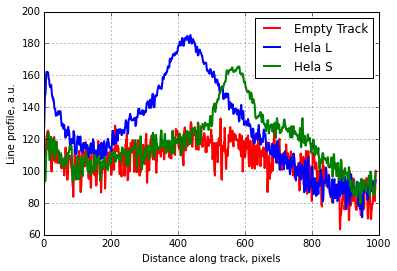

In [3]:
# Plot the profiles
plt.plot(pxEmpty, blotEmpty, 'r', label = 'Empty Track', linewidth = 2)
plt.plot(pxL,     blotL,     'b', label = 'Hela L',      linewidth = 2)
plt.plot(pxS,     blotS,     'g', label = 'Hela S',      linewidth = 2)

plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend()
plt.show()

The above graph shows the raw, line-average profiles through the Southern blots. Next, we need to convert the x-axis to genomic length using the known ladder ticks.

## Converting the x-axis to genomic length (units of kb)

### Find the ladder tick locations

I now need to convert the x-axis from pixels to genomic length, in units of kilobases. This is done with the help of the ladder profiles.

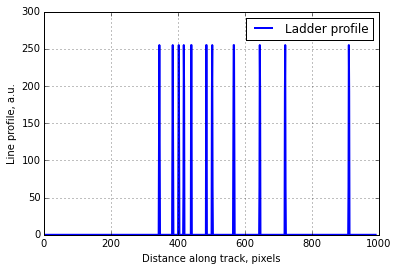

In [4]:
# Define the scale ticks
ladderTicks = np.array([48.5, 38.4, 33.4, 29.9, 24.2, 17, 15, 10, 7 ,5, 3])

# Plot the line profiles through the scales
plt.plot(pxScale, blotScale, label = 'Ladder profile', linewidth = 2)
plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.show()

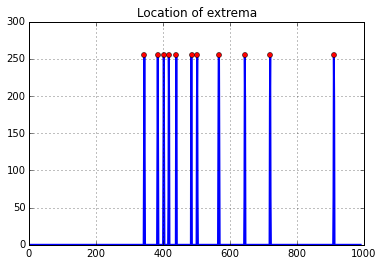

In [5]:
from scipy.signal import argrelextrema

# Find locations of the ticks in pixels
extrema = argrelextrema(blotScale, np.greater)[0]

# Filter extrema by their y-value
extrema = extrema[blotScale[extrema] > 200]

# Manually add missing points
extrema = sorted(np.append(extrema, [441, 486, 567]))

plt.plot(pxScale, blotScale, label = 'Ladder', linewidth = 2)
plt.plot(extrema, blotScale[extrema], 'ro', markersize = 5)
plt.grid(True)
plt.title('Location of extrema')
#plt.xlim((560, 580))
plt.show()

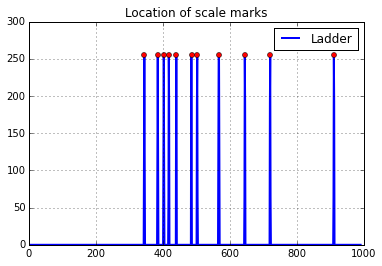

In [6]:
# Build the array of ticks corresponding to ladder marks
ticks = extrema

# Check that tick locations have been found correctly
plt.plot(pxScale, blotScale, label = 'Ladder', linewidth = 2)
plt.plot(ticks, blotScale[ticks], 'ro', markersize = 5)
plt.grid(True)
plt.title('Location of scale marks')
plt.legend(loc = 'best')
plt.show()

Now, let's fit a power law to the extrema so we can convert pixels to kilobases.

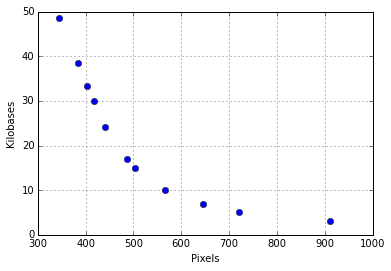

In [7]:
# Plot kilobases vs. pixels
plt.plot(ticks, ladderTicks,  'o', label = 'Ladder')
plt.xlabel('Pixels')
plt.ylabel('Kilobases')
plt.grid(True)

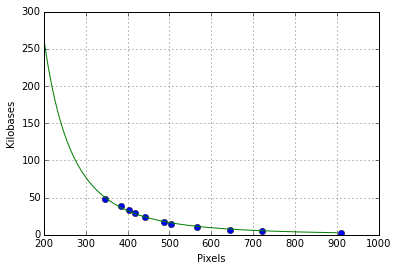

In [8]:
# Fit a power law to the above plot
def fitFunc(x, a0, a1):
    return a0 * x ** a1

xData = ticks
yData = ladderTicks

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitFunc, xData, yData)

# Check the curve fit
x = np.arange(200, 900)
plt.plot(ticks,  ladderTicks,  'o', label = 'Ladder')
plt.plot(x, fitFunc(x, popt[0], popt[1]), label = 'Fit')
plt.xlabel('Pixels')
plt.ylabel('Kilobases')
plt.grid(True)
plt.show()

Now we have a conversion from pixels along the blot tracks to kilobases.

Let's now plot the line profiles as a function kilobases and see how they look.

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


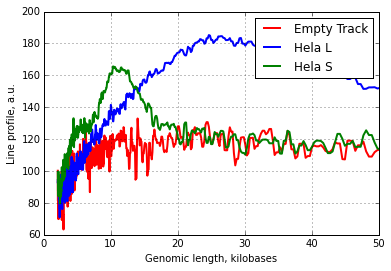

In [9]:
# Plot the profiles
plt.plot(fitFunc(pxEmpty, popt[0], popt[1]), blotEmpty, 'r', label = 'Empty Track', linewidth = 2)
plt.plot(fitFunc(pxL,     popt[0], popt[1]), blotL,     'b', label = 'Hela L',      linewidth = 2)
plt.plot(fitFunc(pxS,     popt[0], popt[1]), blotS,     'g', label = 'Hela S',      linewidth = 2)
plt.xlabel('Genomic length, kilobases')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend()
plt.xlim(0, 50)
plt.show()

## Converting a line profile into probability density

Let's first smooth the empty track data and subtract it from the curves. The empty track serves as our "noise floor."

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


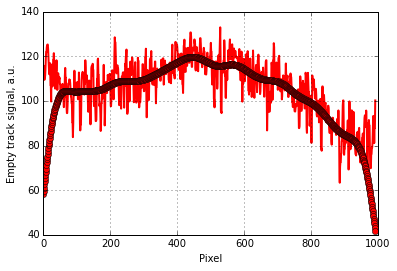

In [10]:
from scipy.signal import gaussian, convolve
#windowWidth = 20
#b = gaussian(windowWidth, 10)
windowWidth = 1000
b = gaussian(windowWidth, 30)
noisefloor = convolve(blotEmpty, b/b.sum())
noisefloor = noisefloor[(windowWidth / 2):(1-windowWidth/2)]

plt.plot(pxEmpty, blotEmpty, color = 'red', label = 'Empty track', linewidth = 2)
plt.plot(pxEmpty, noisefloor, 'ro')
plt.xlabel('Pixel')
plt.ylabel('Empty track signal, a.u.')
plt.grid(True)

The severe drop in the smoothed curve at the edges is due to the sliding Window. These values are not near the signal and will be cropped out later.

In [11]:
blotL     = blotL     - noisefloor
blotS     = blotS     - noisefloor
blotEmpty = blotEmpty - noisefloor

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


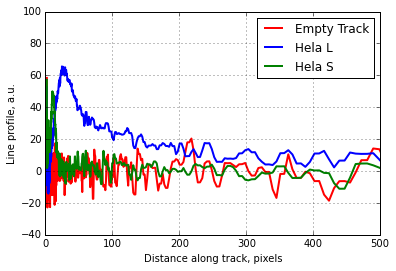

In [12]:
# Check that the noise has been subtracted
plt.plot(fitFunc(pxEmpty, popt[0], popt[1]), blotEmpty, 'r', label = 'Empty Track', linewidth = 2)
plt.plot(fitFunc(pxL,     popt[0], popt[1]), blotL,     'b', label = 'Hela L',      linewidth = 2)
plt.plot(fitFunc(pxS,     popt[0], popt[1]), blotS,     'g', label = 'Hela S',      linewidth = 2)
plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.xlim(0, 500)
plt.grid(True)
plt.legend()
plt.show()

Now that we've got the noise removed, let's rescale the whole x-axis by dividing by the genomic length. This removes the bias introduced by longer telomeres having a larger signal.

We can also account for the subtelomeric fragment length, which contributes to a perceived increase in molecular weight in the gel. This is because the restriction fragment can contain the subtelomere sequence, effectively slowing it in the gel, but the hybridizing label will only attach to the true telomere repeat sequence. An independent measurement of subtelomeric length must be made for the telomere restriction fragment assessment to be truly accurate.

For us, this independent measurement was the dot blot performed on the Hela L and Hela S cell lines. This allows us to fix the ratio of the means.

In [13]:
MW = fitFunc(pxL, popt[0], popt[1]) # pxL, and pxS should be identical

subTeloOffset = 0.419 # Units of kb; consistent with reports in the literature
MW = MW - subTeloOffset

# Do not divide by molecular weight anymore!
cBlotL = blotL
cBlotS = blotS

# Flip arrays for convenience in cropping later
MW     = np.flipud(MW)
blotL  = np.flipud(blotL)
blotS  = np.flipud(blotS)
cBlotL = np.flipud(cBlotL)
cBlotS = np.flipud(cBlotS)

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


Now we need to find where the curves cross zero, since data beyond these points are likely noise and not actually part of the distributions.

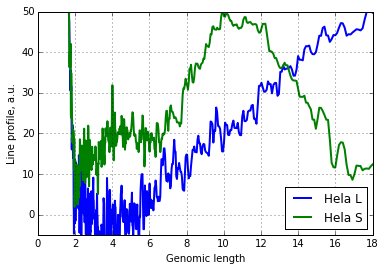

In [14]:
# Zoom into low genomic length areas to find the zero-crossing or point where curves reach the noise
plt.plot(MW, cBlotL, label = 'Hela L', linewidth = 2)
plt.plot(MW, cBlotS, label = 'Hela S', linewidth = 2)
plt.xlabel('Genomic length')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.xlim(0, 18)
plt.ylim(-5,50)
plt.show()

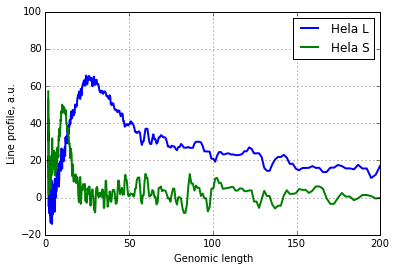

In [15]:
# See the whole curves
plt.plot(MW, cBlotL, label = 'Hela L', linewidth = 2)
plt.plot(MW, cBlotS, label = 'Hela S', linewidth = 2)
plt.xlabel('Genomic length')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.xlim(0,200)
plt.show()

Let's crop these curves to make them easier to work with, to be more consistent with the dot blot measurements, and to remove bias introduced by undigested material.

It's unlikely that telomeres are going to be greater than about 500 kb long, so we'll set this as the absolute upper limit for Hela L. Furthermore, based on the above graph and the original Southern blots, it looks like anything less than about 4 kb is probably noise. The effects of cropping the distributions, which is a necessary step, are discussed in [Oexle, 1998](http://www.sciencedirect.com/science/article/pii/S0022519397905592).

In [16]:
# Both lower bounds are estimated from the points where there is a sudden spike in the noise and curve y-axis values.
# See the graph above.
cropLow = 6

cropL = (cropLow, 500) # Hela L flat has an inflection point around 50 kb, suggesting undigested material
cropS = (cropLow, 16) # Hela S reaches the noise at ~16 kb and remains more-or-less constant for values > 20 kb
# Crop the arrays to make them easier to work with
MWL = MW.copy()
MWS = MW.copy()

blotLcr  = blotL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]
cBlotLcr = cBlotL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]

blotScr  = blotS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]
cBlotScr = cBlotS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]

MWL = MWL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]
MWS = MWS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]

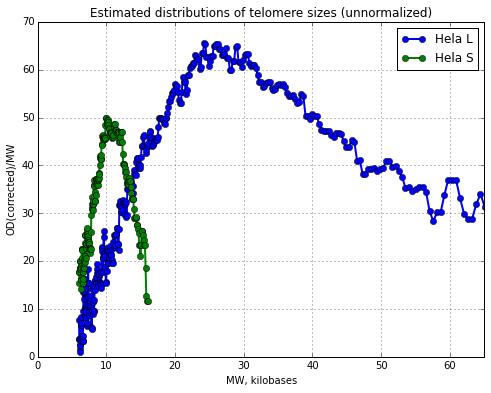

In [17]:
plt.figure(figsize = (8,6))
plt.plot(MWL, cBlotLcr, '-o', label = 'Hela L', linewidth = 2)
plt.plot(MWS, cBlotScr, '-o', label = 'Hela S', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(corrected)/MW')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized)')
plt.xlim(0, 65)
plt.show()

Hela L clearly has a very long tail, so we will likely have to crop it one more time at long lengths once we're done processing it. Let's compute the means of these distributions.

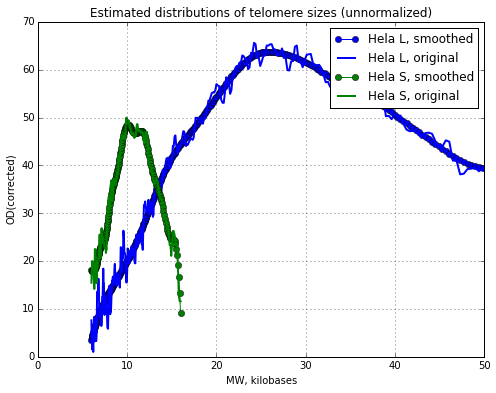

In [18]:
# Smooth the corrected curves
from scipy.interpolate import UnivariateSpline
splLcorr = UnivariateSpline(MWL, cBlotLcr)
splScorr = UnivariateSpline(MWS, cBlotScr)

splLcorr.set_smoothing_factor(2000)
splScorr.set_smoothing_factor(500)

plt.figure(figsize = (8,6))
plt.plot(MWL, splLcorr(MWL), '-o', label = 'Hela L, smoothed', linewidth = 1)
plt.plot(MWL, cBlotLcr,      'b',  label = 'Hela L, original', linewidth = 2)
plt.plot(MWS, splScorr(MWS), '-o', label = 'Hela S, smoothed', linewidth = 1)
plt.plot(MWS, cBlotScr,      'g',  label = 'Hela S, original', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(corrected)')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized)')
plt.xlim(0, 50)
plt.show()

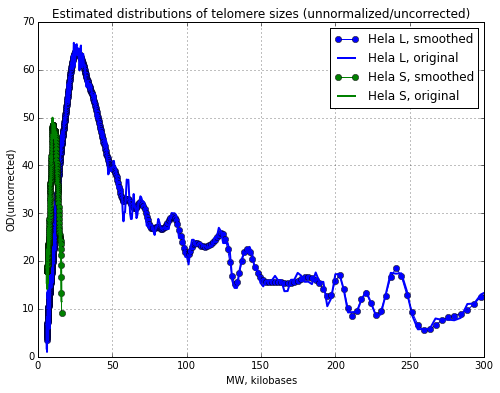

In [19]:
# Smooth the uncorrected curves
splL = UnivariateSpline(MWL, blotLcr)
splS = UnivariateSpline(MWS, blotScr)

splL.set_smoothing_factor(2000)
splS.set_smoothing_factor(500)

plt.figure(figsize = (8,6))
plt.plot(MWL, splL(MWL), '-o', label = 'Hela L, smoothed', linewidth = 1)
plt.plot(MWL, blotLcr,    'b', label = 'Hela L, original', linewidth = 2)
plt.plot(MWS, splS(MWS), '-o', label = 'Hela S, smoothed', linewidth = 1)
plt.plot(MWS, blotScr,    'g', label = 'Hela S, original', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(uncorrected)')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized/uncorrected)')
plt.xlim(0, 300)
plt.show()

From the graph above it looks like the inflection point in the Hela L distribution is around 60 kb, so any cropping of the distributions should probably occur around there.

## Find FWHM of curves above

Given the difficulty in applying quantitative Southern blot techniques to HeLa long, we can instead use the peak values of the Southern blots as estimates of the mean. (According Oexle, the peak of the optical density curve is the least biased estimate of the mean when Southern blots are subjected to cropping and most "real" analyses.) Then, we will estimate the full widths of the telomere distributions as equivalent to the FWHM of of the above curves. We will not correct for the the length-dependent signal since this correction has not, as far as I know, been shown to work with long telomeres spanning a signficant fraction of an order of magnitude. The length-dependent correction should only work when the hybridization efficiency is roughly constant.

In [20]:
maxL = MWL[splLcorr(MWL) == np.max(splLcorr(MWL))]
maxS = MWS[splScorr(MWS) == np.max(splScorr(MWS))]

In [21]:
# max values of the distributions
maxValueL = splLcorr(MWL[MWL == maxL])
maxValueS = splScorr(MWS[MWS == maxS])

# half maximum values
halfMaxL = maxValueL / 2
halfMaxS = maxValueS / 2

In [22]:
# Crop x-values to get the FWHM curves
MWL = MWL[splLcorr(MWL) > halfMaxL]
MWS = MWS[splScorr(MWS) > halfMaxS]

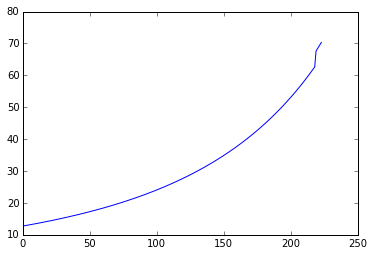

In [23]:
plt.plot(MWL)
plt.show()

In [24]:
# Remove the last points in MWL that survived the half max filtering
print(MWL[-10:])
MWL = MWL[:-5]
print(MWL[-10:])

[ 60.33170791  60.90042533  61.47624958  62.05929187  62.64966554
  67.65091099  68.31273558  68.98315063  69.6622958   70.35031351]
[ 57.59097128  58.12575277  58.66711482  59.21515884  59.76998814
  60.33170791  60.90042533  61.47624958  62.05929187  62.64966554]


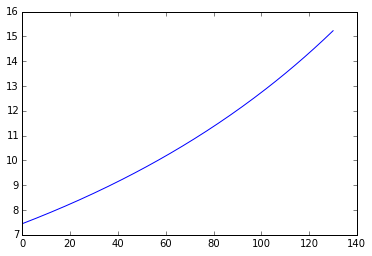

In [25]:
plt.plot(MWS)
plt.show()

Finally, we want to ensure that the ratio of the means of the Southern blots match the dot blots. We'll do this by adjusting the right-most cropping point on HeLa L until the ratio of the mean values (determined below) of HeLa L to HeLa S equals ~3, which is what we got from the dot blots. (This step was done iteratively by adjusting the upper crop point and running the rest of the worksheet down to the part where the means were calculated.)

In [26]:
MWL = MWL[MWL < 58]

These values for the cropping points are also consistent with the Southern blot image, where there is very little signal above ~60 kb and below ~5 kb.

## Finding the statistics from these distributions

The above plots contain the **unnormalized** probability density functions for the Hela telomere genomic lengths. I need to make them **normalized distributions**.

Our dot blot data suggests that the ratio of the means should be around 3, so the two numbers for mean estimates from the Southern blots should be consistent with the dot blot data. This is because the error in the dot blots is significantly less than the Southern blots.

Also interesting to note is that the mean value for HeLa S changes by less than one kb when we divide the Southern blot signal by the telomere length. So, so long as we care mostly about having an accurate mean and variance of our distributions, I would say that this method of analysis is correct to a level of accuracy that is necessary for our work.

### Making numeric distributions from the Southern blot data

Now that we have the curves, let's turn them into distributions. We'll first convert the curves to histograms, and then normalize the histograms. This essentially creates probability mass functions.

Note that even though the genomic length and label lengths are discrete variables, it should be OK that I used continuous approximations up to this point. This is because the spacing between allowed values for the genomic length (1 base pair) and probe length (about 300 bp) is much smaller than the spread of the distributions (about 10,000 base pairs). The distributions thus essentially "look" continous.

### The following part on bin computations is not relevant to understanding the analysis and can be skipped.

Please proceed to the section on normalizing the histograms below if this section does not interest you.

---

Because we are now using splines that can be evaluated at any x-position, we can safely create evenly spaced points on the x-axis range and evaluate the spline at this positions.

In [27]:
# Determine bins from the x-axis data
xL = np.linspace(MWL[0], MWL[-1], len(MWL) + 1)
xS = np.linspace(MWS[0], MWS[-1], len(MWS) + 1)

diffL = xL[1] - xL[0]
diffS = xS[1] - xS[0]

Now we can determine the histograms from the (non-normalized) probability densities above, and from the histograms get the normalized probability density estimates.

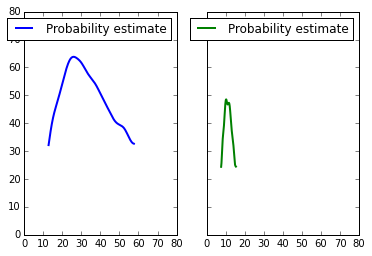

In [28]:
# Check the new histograms
fig, (ax1,ax2) = plt.subplots(1, 2, sharey = True)

ax1.plot(xL, splLcorr(xL), 'b', linewidth = '2', label = 'Probability estimate')
ax2.plot(xS, splScorr(xS), 'g', linewidth = '2', label = 'Probability estimate')

ax1.set_xlim((0, 80))
ax2.set_xlim((0, 80))

ax1.set_ylim((0, 80))

ax1.legend()
ax2.legend()
plt.show()

Now, convert these curves to probability mass densities.

### Normalizing the histograms to get probability mass densities

By definition, the sum of the probabilities of the histogram bins times their width must be one. This can be achieved by dividing by a constant, a technique known as *normalization*. The constant is obtained by integration, i.e. summing the product of the value of the curve times the spacing between the neighboring points. (This last part is easy because I regularly sampled the curve on the x-axis.)

In [29]:
# Integrate to find the normalize constants
normL = np.sum(splLcorr(xL) * diffL)
normS = np.sum(splScorr(xS) * diffS)

# Define the y-values for the curves for easy naming
probL = splLcorr(xL) / normL
probS = splScorr(xS) / normS

print('Integral of Hela L probability mass density: {0}'.format(np.sum(probL * diffL)))
print('Integral of Hela S probability mass density: {0}'.format(np.sum(probS * diffS)))


Integral of Hela L probability mass density: 1.0
Integral of Hela S probability mass density: 0.9999999999999999


# What are the statistical measures of these distributions?

 The mean of a probability mass density $p \left( L \right)$ is simply
 
 \begin{equation*}
 \bar{L} = \sum_{i=1}^{N} L_{i} p \left( L_i \right) \Delta L
 \end{equation*}
 
To compute this, I need to multiply the midpoint of each bin for the genomic length of the telomeres with its probability in the probL and probS arrays, and then sum them.

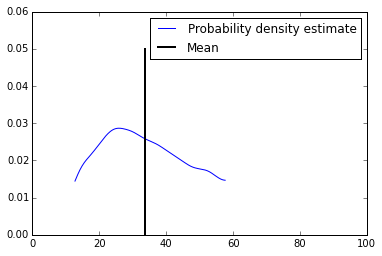

Mean of Hela L: 33.799260881341496


In [30]:
meanL = np.sum(xL * probL * diffL)
meanS = np.sum(xS * probS * diffS)

plt.plot(xL,             probL,     'b', label = 'Probability density estimate')
plt.plot([meanL, meanL], [0, 0.05], 'k', label = 'Mean', linewidth = 2)
plt.legend()
plt.xlim(0, 100)
plt.show()

print('Mean of Hela L: {0}'.format(meanL))

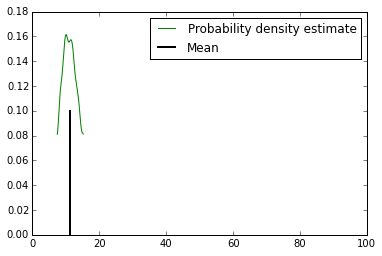

Mean of Hela S: 11.20126504420635


In [31]:
plt.plot(xS,             probS,   'g', label = 'Probability density estimate')
plt.plot([meanS, meanS], [0, .1], 'k', label = 'Mean', linewidth = 2)
plt.legend()
plt.xlim(0, 100)
plt.show()

print('Mean of Hela S: {0}'.format(meanS))

### Median values

The median values are the points where the cumulative distributions are 0.5; this means 50% of the area below the curve lies on each side of the median value. For skewed distributions such as these, it is often preferred over the mean as a measure of central tendency.

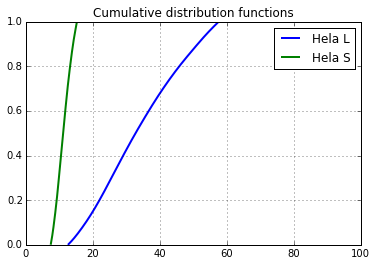

Hela L Median: 32.70955406732128
Hela S Median: 11.099943820731584


In [32]:
cdfL = np.cumsum(probL * diffL)
cdfS = np.cumsum(probS * diffS)

medianL = (max(xL[cdfL < 0.5]) + min(xL[cdfL > 0.5])) / 2
medianS = (max(xS[cdfS < 0.5]) + min(xS[cdfS > 0.5])) / 2

# Plot the cumulative distribution functions
plt.plot(xL, cdfL, label = 'Hela L', linewidth = 2)
plt.plot(xS, cdfS, label = 'Hela S', linewidth = 2)
plt.grid(True)
plt.title('Cumulative distribution functions')
plt.legend(loc = 'best')
plt.xlim(0, 100)
plt.show()

print('Hela L Median: {0}\nHela S Median: {1}'.format(medianL, medianS))

### Estimate the standard deviations

In [33]:
# Second central moments of the distributions
secondCentMomL = np.sum((xL - meanL)**2 * probL * diffL)
secondCentMomS = np.sum((xS - meanS)**2 * probS * diffS)

# Standard deviations of the distributions
stdL = np.sqrt(secondCentMomL)
stdS = np.sqrt(secondCentMomS)

print('Hela L standard deviation: {0:.2f}'.format(stdL))
print('Hela S standard deviation: {0:.2f}'.format(stdS))

Hela L standard deviation: 12.07
Hela S standard deviation: 2.05


# Maximum entropy distributions

If we can only know the mean and standard deviation, then a maximum entropy argument would state that we should choose a Gaussian distribution for the probability. Here's what the equivalent Gaussian's look like relative to the measured probabilities.

**Note:** This reasoning is wrong but I leave it here for historical reasons.

In [34]:
from scipy.stats import norm

In [35]:
# Define Gaussians with the measured moments
maxEntL = norm(loc = meanL, scale = stdL)
maxEntS = norm(loc = meanS, scale = stdS)

(0, 0.05)

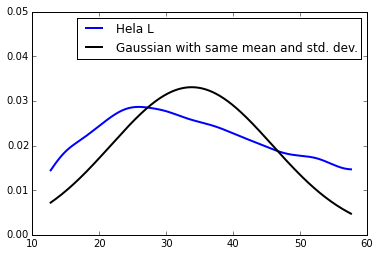

In [36]:
plt.plot(xL, probL, label = 'Hela L', linewidth = 2)
plt.plot(xL, maxEntL.pdf(xL), linewidth = 2, color = 'black', label = 'Gaussian with same mean and std. dev.')
plt.legend()
plt.ylim((0, 0.05))

The Gaussian with these parameters does not look like a very good match. Why?

We also know, though, the the length can't be less than zero. This means that this maximum entropy model, which involves plugging in the mean and standard deviation into a Gaussian, is not likely correct. Furthermore, the skew in the distribution is quite severe, which precludes a Gaussian model.

I also know that the very long tail at high genomic lengths is probably due to undigested material in the gel track (extra radio labels, undigested DNA, etc... I can see smears sometimes in the ladders), so the long tails should not be weighted so heavily. In fact, I would expect the larger the value of the distribution, the higher the weight we can place on the distribution. So really, we know quite a lot more than the mean and standard deviation.

In my original estimates, I used a uniform distribution with edges set to the full width half max of the very first corrected distributions. This step imposes few assumptions on the distribution given what we know: the Southern blot data, the model to get the probability of genomic lengths, the fact that the genomic length can't be less than zero, and undigested material leads to a long tail in the measured distributions, so maybe it would serve better as a max. ent. distribution.

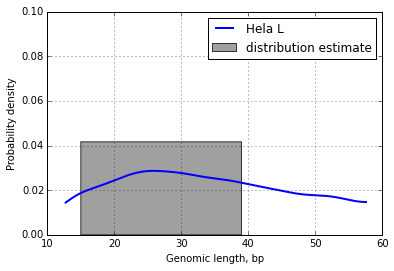

In [37]:
# Plot the probability between the points correspoinding to half its maximum
plt.plot(xL, probL, label = 'Hela L', linewidth = 2)

# Plot the approximate distribution to use for the simulations
plt.hist([26.5, 27.5], bins = [15, 27, 39], histtype = 'stepfilled', color = 'gray', alpha = 0.75, label = 'distribution estimate', normed = True)
plt.legend()
plt.xlabel('Genomic length, bp')
plt.ylabel('Probability density')
plt.ylim(0, 0.1)
plt.grid()
plt.show()

For the simulations, I originally used the gray distribution estimate above, which has a mean of about 27 kb and a width of about 12 kb. One can see that I missed a significant fraction of long telomeres in the original simulations.

# How many base pairs can we expect?

The dot blot intensities should be proportional to the total amount of DNA in the blot: this is equivalent to randomly sampling from the above distributions a large number of times and adding the total amount of DNA together. We would like to know if the ratio of means from the quantitative Southern blots should be equal to the ratio of means of the dot blots.

We can run a numerical experiment to simulate a dot blot to see whether this is true. Being able to select random numbers from this distribution, though, requires converting between CDF's, which isn't exactly straight forward for non-analytical distributions.

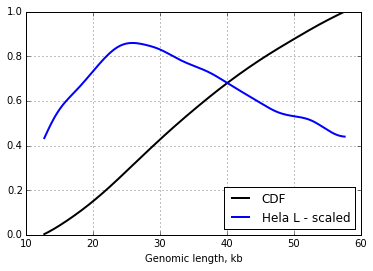

In [38]:
# Plot the cumulative distribution and its unnormalized PDF
plt.plot(xL, cdfL, color = 'black', label = 'CDF', linewidth = 2)
plt.plot(xL, probL * 30, label = 'Hela L - scaled', linewidth = 2)
plt.grid(True)
plt.legend(loc = 'lower right')
plt.xlabel('Genomic length, kb')
plt.show()

In [39]:
# Write function that returns a MW value for a given CDF value

from scipy.interpolate import interp1d

def cdf2MW(MW, cdf, cumValue):
    """MW       : array of molecular weight values
       cdf      : array of cdf values
       cumValue : value of the cumulative distribution to interpolate
    """
    if cumValue < min(cdf):
        return min(cdf)
    elif cumValue > max(cdf):
        return max(cdf)
    else:
        f = interp1d(cdf, MW)
        return f(cumValue)

# Check that it works
print('Interpolated x-value at cdf = 0.6 for Hela L: {0}'.format(cdf2MW(xL, cdfL, 0.6)))
print('Bin location just below cdf = 0.6: {0}'.format(max(xL[cdfL < 0.6])))
print('Bin location just above cdf = 0.6: {0}'.format(min(xL[cdfL > 0.6])))

Interpolated x-value at cdf = 0.6 for Hela L: 36.674008435002975
Bin location just below cdf = 0.6: 36.66068040645926
Bin location just above cdf = 0.6: 36.874254803169414


Now we can simulate a dot blot by drawing a large number of telomeres from the Southern blot distribution, adding up all the genomic lengths from the simulation, and taking the ratio of the sums for HeLa L and HeLa S. This ratio can be compared to the mean values derived from the Southern blot analysis.

In [40]:
# Now, run the numerical experiments.
# Generate a random uniform number between 0 and 1;
# Then, find the corresponding value from the CDF.
numTelomeres = int(1e6) # Number of telomeres to generate
randNums     = np.random.rand(numTelomeres)
experimentL  = np.zeros(numTelomeres)
experimentS  = np.zeros(numTelomeres)
maxL         = np.max(xL)
maxS         = np.max(xS)

# DO NOT do a list comprehension since the arrays are so large
for ctr in range(numTelomeres):
    experimentL[ctr] = cdf2MW(xL, cdfL, randNums[ctr])
    experimentS[ctr] = cdf2MW(xS, cdfS, randNums[ctr]) 

In [41]:
# What are the outcomes?
totalL = np.sum(experimentL)
totalS = np.sum(experimentS)

In [42]:
print('Total number of basepairs, Hela L: {0}'.format(totalL))
print('Total number of basepairs, Hela S: {0}'.format(totalS))
print('Ratio of totals: {0}'.format(totalL / totalS))
print('Ratio of means:  {0}'.format(meanL / meanS))

Total number of basepairs, Hela L: 33643136.39932582
Total number of basepairs, Hela S: 11133415.42322018
Ratio of totals: 3.021816317853253
Ratio of means:  3.0174503279719773


So, even for very skewed distributions, **the ratio of the total amount of telomeric DNA is equal to the ratio of the means of the distribution.**

This means that the ratio of the dot blot intensities should equal the ratio of the mean values from the Southern blots. **Because the dot blot ratios are ~3 and we can place a high degree of belief in the dot blots, this means that the Southern blots are likely subject to some noise.** The different ways to estimate the means described above also corroborates this fact. I expect that the Hela L telomeres are more heavily biased since their spread in lengths is much larger than Hela S. Also, since correcting for the telomere length in the Southern blots doesn't change the mean by a large amount, I would guess that most of the bias in the Southern blots comes from variation in the hybridization at long telomere lengths.

# Can experimentL and experimentS be used as telomere length data?

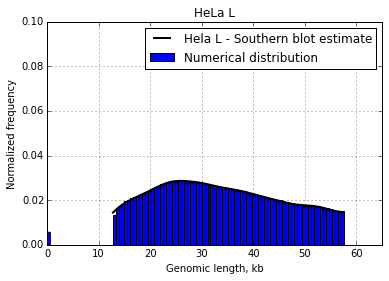

In [43]:
plt.hist(experimentL, bins = 100, label = 'Numerical distribution', normed = True)
plt.plot(xL, probL, 'k', label = 'Hela L - Southern blot estimate', linewidth = 2)
plt.xlabel('Genomic length, kb')
plt.ylabel('Normalized frequency')
plt.title('HeLa L')
plt.xlim(0, 65)
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.plot()
plt.show()

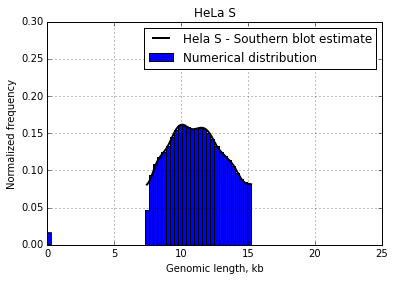

In [44]:
plt.hist(experimentS, bins = 50, label = 'Numerical distribution', normed = True)
plt.plot(xS, probS, 'k', label = 'Hela S - Southern blot estimate', linewidth = 2)
plt.xlabel('Genomic length, kb')
plt.ylabel('Normalized frequency')
plt.title('HeLa S')
plt.xlim(0, 25)
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.plot()
plt.show()

The only thing to be done is to remove the zero values from these distributions. Since I normally run the polymer simulations with 100,000 realizations but here simulated 1,000,000 genomic lengths, I can simply crop these low genomic length values from the array and simulate a random sample of 100,000 in the polymer code.

In [45]:
# Remove values from below the crop threshold.
experimentL = experimentL[experimentL > cropLow]
experimentS = experimentS[experimentS > cropLow]

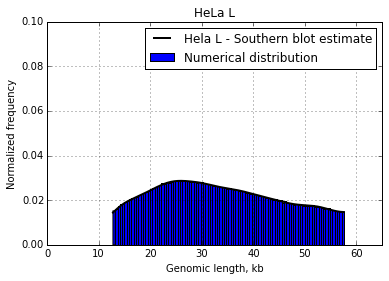

In [46]:
plt.hist(experimentL, bins = 100, label = 'Numerical distribution', normed = True)
plt.plot(xL, probL, 'k', label = 'Hela L - Southern blot estimate', linewidth = 2)
plt.xlabel('Genomic length, kb')
plt.ylabel('Normalized frequency')
plt.title('HeLa L')
plt.xlim(0, 65)
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.plot()
plt.show()

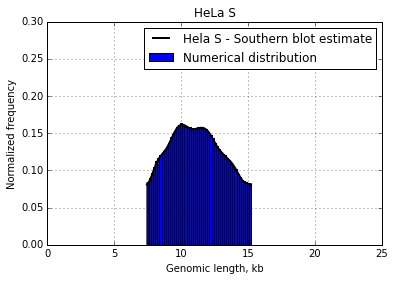

In [47]:
plt.hist(experimentS, bins = 50, label = 'Numerical distribution', normed = True)
plt.plot(xS, probS, 'k', label = 'Hela S - Southern blot estimate', linewidth = 2)
plt.xlabel('Genomic length, kb')
plt.ylabel('Normalized frequency')
plt.title('HeLa S')
plt.xlim(0, 25)
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.plot()
plt.show()

In [55]:
# Save the genomic lengths
np.savetxt('HeLaLGenomicLength.txt', experimentL)
np.savetxt('HeLaSGenomicLength.txt', experimentS)

# Log-normal distribution

I can try a log-normal distribution as a distribution of telomere lengths as well.

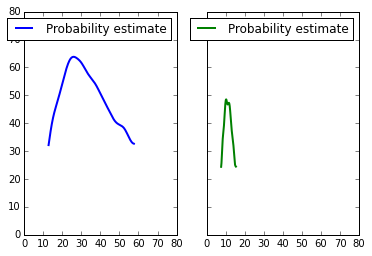

In [49]:
# Check that the histograms and probabilities match
fig, (ax1,ax2) = plt.subplots(1, 2, sharey = True)

ax1.plot(xL, splLcorr(xL), 'b', linewidth = '2', label = 'Probability estimate')

ax2.plot(xS, splScorr(xS), 'g', linewidth = '2', label = 'Probability estimate')

ax1.set_xlim((0, 80))
ax2.set_xlim((0, 80))

ax1.set_ylim((0, 80))

ax1.legend()
ax2.legend()
plt.show()

In [50]:
maxL = xL[splLcorr(xL) == np.max(splLcorr(xL))]
maxS = xS[splScorr(xS) == np.max(splScorr(xS))]

In [51]:
print(maxL)
print(maxS)

[ 25.98196057]
[ 10.06046012]


In [52]:
print('Ratio of means: {0}'.format(meanL / meanS))
print('Ratio of maxima: {0}'.format(maxL / maxS))

Ratio of means: 3.0174503279719773
Ratio of maxima: [ 2.58258174]
